In [3]:
import pandas as pd
import pyarrow.parquet as pq 
train = pq.read_table(source='C:/Users/tomas/OneDrive/Escritorio/ORGA DE DATOS/train').to_pandas()
test = pq.read_table(source='C:/Users/tomas/OneDrive/Escritorio/ORGA DE DATOS/test').to_pandas()

In [4]:
for column in train:
    if(column == "content"):
        train[column].fillna(value="",inplace=True)
    else:
        if(train[column].isnull().sum() != 0):
            media = train[column].mean()
            train[column].fillna(value=media, inplace=True)
            
for column in test:
    if(column == "content"):
        test[column].fillna(value="",inplace=True)
    else:
        if(test[column].isnull().sum() != 0):
            media = test[column].mean()
            test[column].fillna(value=media, inplace=True)            

In [5]:
train = train.iloc[:(8*len(train)//10)]
valid = train.iloc[(8*len(train)//10):]

In [6]:
X_train = train.drop(['url','timedelta','popular','shares'],axis = 1)
y_train = train["popular"]*1

In [7]:
X_valid = valid.drop(['url','timedelta','popular','shares'],axis = 1)
y_valid = valid["popular"]*1

In [8]:
X_test = test.drop(['url','timedelta','popular','shares'],axis = 1)
y_test = test["popular"]*1

In [9]:
import zstandard
import gzip
def compress_size(bytefile):
    return len(gzip.compress((bytefile.encode()),compresslevel=1))


def ncd(st1,st2):
    len1 = compress_size(st1)
    len2 = compress_size(st2)
    concat_len =  compress_size(st1+st2)
    return (concat_len - min(len1,len2))/max(len1,len2)

In [10]:
from sklearn.preprocessing import OneHotEncoder
ohe_surprise1 = OneHotEncoder()
encoded_surp = ohe_surprise1.fit_transform(X_train[["surprise1"]]).toarray()
encoded_surp_test = ohe_surprise1.transform(X_test[["surprise1"]]).toarray()
encoded_surp_valid = ohe_surprise1.transform(X_valid[["surprise1"]]).toarray()

import numpy as np
feature_labels = np.array(ohe_surprise1.categories_).ravel()
X_train = X_train.reset_index().drop(['index','surprise1'],axis = 1).join(pd.DataFrame(encoded_surp, columns = feature_labels))
X_test = X_test.reset_index().drop(['index','surprise1'],axis = 1).join(pd.DataFrame(encoded_surp_test, columns = feature_labels))
X_valid = X_valid.reset_index().drop(['index','surprise1'],axis = 1).join(pd.DataFrame(encoded_surp_valid, columns = feature_labels))

In [11]:
from sklearn.preprocessing import LabelBinarizer
ohe_surprise2 = LabelBinarizer()
encoded_surp2 = ohe_surprise2.fit_transform(X_train[["surprise2"]])
encoded_surp2_test = ohe_surprise2.transform(X_test[["surprise2"]])
encoded_surp2_valid = ohe_surprise2.transform(X_valid[["surprise2"]])

feature_labels = np.array(ohe_surprise2.classes_).ravel()
X_train = X_train.reset_index().drop(['index','surprise2'],axis = 1).join(pd.DataFrame(encoded_surp2, columns = feature_labels))
X_test = X_test.reset_index().drop(['index','surprise2'],axis = 1).join(pd.DataFrame(encoded_surp2_test, columns = feature_labels))
X_valid = X_valid.reset_index().drop(['index','surprise2'],axis = 1).join(pd.DataFrame(encoded_surp2_valid, columns = feature_labels))


In [12]:
X_train.content = X_train.content.apply(lambda x: compress_size(x))
X_test.content = X_test.content.apply(lambda x: compress_size(x))
X_valid.content = X_valid.content.apply(lambda x: compress_size(x))

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.linear_model import LogisticRegression

In [14]:
lr = LogisticRegression()

tuned_parameters = {
    'penalty': ['l1','l2','elasticnet','none'],
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter': [100,1000,2500,5000]
}

In [15]:
rs = RandomizedSearchCV(estimator = lr, param_distributions = tuned_parameters, cv = 10, verbose = 2, n_jobs = -1, random_state = 42)

In [16]:
rs.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


C:\Users\tomas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tomas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tomas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tomas\AppData\Local\Programs\Python

RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': [100, 1000, 2500, 5000],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, verbose=2)

In [17]:
print(rs.best_score_)

0.7919032597266036


In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [19]:
modeloPrueba = rs.best_estimator_
modeloPrueba.fit(X_train,y_train)

C:\Users\tomas\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


LogisticRegression(C=78.47599703514607, solver='newton-cg')

In [20]:
print(f'Accuracy - : {modeloPrueba.score(X_train,y_train):.3f}')

Accuracy - : 0.792


In [21]:
prediccion_binaria = modeloPrueba.predict(X_valid)
prediccion_binaria

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
proba_preds = modeloPrueba.predict_proba(X_valid)[:,1]
proba_preds

array([0.11758953, 0.15583582, 0.08916277, ..., 0.18357913, 0.17172309,
       0.23039515])

In [23]:
print(classification_report(y_valid, prediccion_binaria))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      4586
           1       0.49      0.07      0.12      1120

    accuracy                           0.80      5706
   macro avg       0.65      0.52      0.50      5706
weighted avg       0.75      0.80      0.74      5706



In [24]:
#MEJOR SCORE DE VALIDACION OBTENIDO
roc_auc_score(y_valid,proba_preds)

0.6904361488380787

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

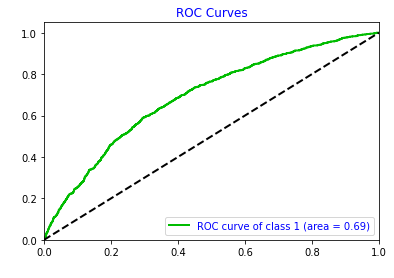

In [25]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_valid, modeloPrueba.predict_proba(X_valid), classes_to_plot=1,plot_micro=False,plot_macro=False, 
                      figsize = plt.rcParams.update({'text.color': 'blue', 'axes.labelcolor': 'white'}))

In [26]:
#FEATURE IMPORTANCE

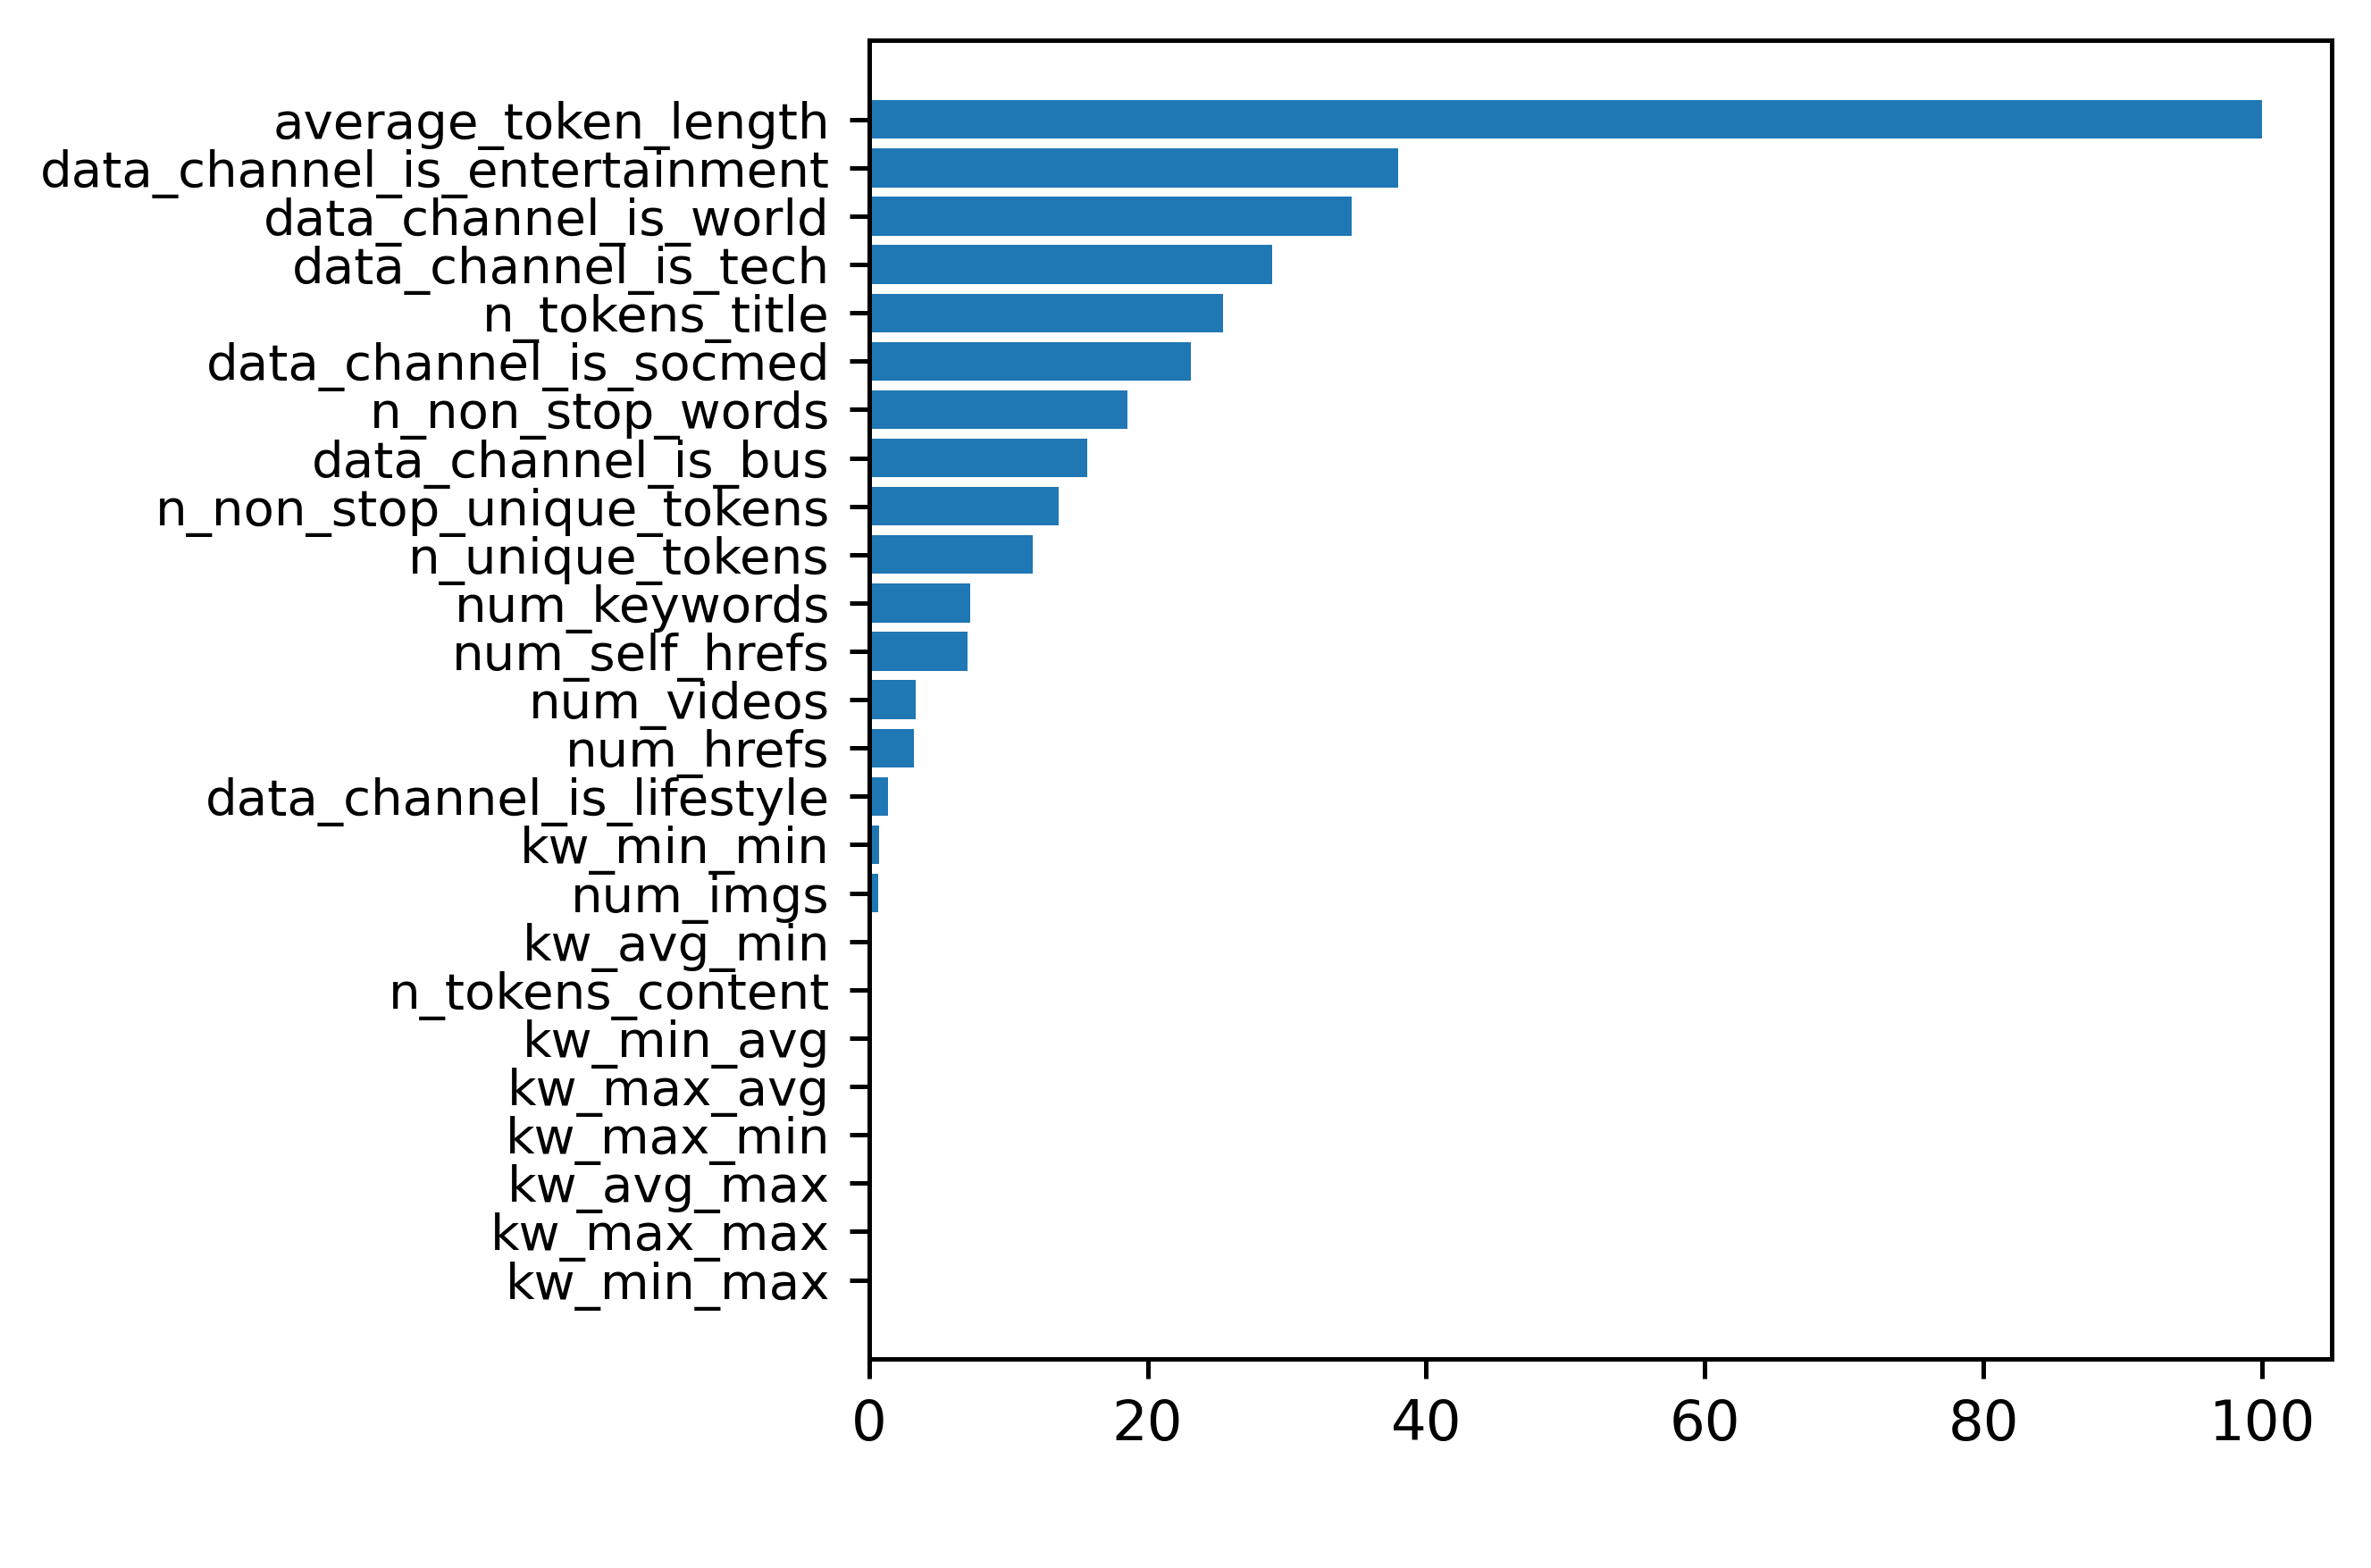

In [27]:
import matplotlib.pyplot as plt
feature_importance = abs(modeloPrueba.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance[0:25])
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(dpi = 450)
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(X_train.columns[sorted_idx], fontsize=9)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [28]:
#CSV
nuevo_df = test
df_test = nuevo_df.reset_index().drop(['index'],axis = 1).join(pd.DataFrame(modeloPrueba.predict_proba(X_test),columns = ["False","True"]))

In [34]:
#CSV
df_test[["popular","False","True"]]

,popular,False,True
0,False,0.869322,0.130678
1,False,0.802698,0.197302
2,False,0.878462,0.121538
3,False,0.808404,0.191596
4,True,0.857829,0.142171
...,...,...,...
3976,False,0.832533,0.167467
3977,False,0.710620,0.289380
3978,False,0.693601,0.306399
3979,False,0.870364,0.129636


In [35]:
#SCORE DE TEST
roc_auc_score(y_test, modeloPrueba.predict_proba(X_test)[:,1])

0.6939021620190028